In [11]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx


In [74]:
dataset = KarateClub()
graph = dataset[0]
print('ノード数: {}'.format(graph.num_nodes))
print('辺の数: {}'.format(graph.num_edges))
print('ノードの特徴量数: {}'.format(graph.num_node_features))
print('ノード同士の繋がり: {}'.format(graph['edge_index']))

ノード数: 34
辺の数: 156
ノードの特徴量数: 34
ノード同士の繋がり: tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
         

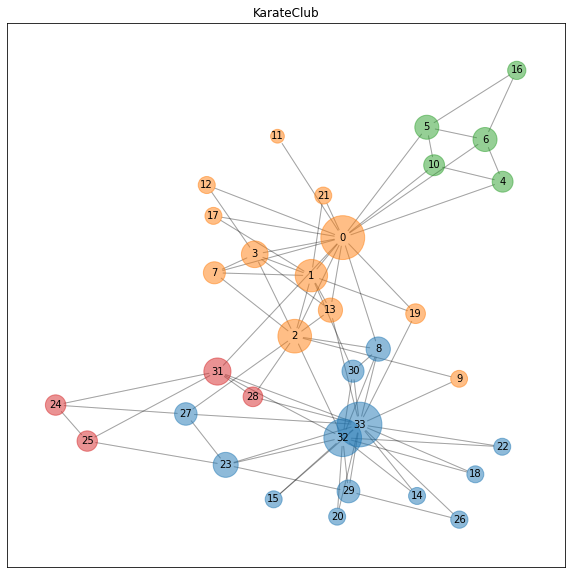

In [76]:

nxg = to_networkx(graph)
pr = nx.pagerank(nxg)
pr_max = np.array(list(pr.values())).max()
draw_pos = nx.spring_layout(nxg, seed=0) 

cmap = plt.get_cmap('tab10')
labels = graph.y.numpy()
colors = [cmap(l) for l in labels]


plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(nxg, 
                       draw_pos,
                       node_size=[v / pr_max * 2000 for v in pr.values()],
                       node_color=colors, alpha=0.5)
nx.draw_networkx_edges(nxg, draw_pos, arrowstyle='-', alpha=0.2)
nx.draw_networkx_labels(nxg, draw_pos, font_size=10)

plt.title('KarateClub')
plt.show()

In [33]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_size = 5
        self.conv1 = GCNConv(dataset.num_node_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, dataset.num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [90]:
model = Net()

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    optimizer.zero_grad()
    out = model(graph)
    loss = F.nll_loss(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.3451
Epoch 1 | Loss: 1.3334
Epoch 2 | Loss: 1.3208
Epoch 3 | Loss: 1.3074
Epoch 4 | Loss: 1.2937
Epoch 5 | Loss: 1.2796
Epoch 6 | Loss: 1.2652
Epoch 7 | Loss: 1.2503
Epoch 8 | Loss: 1.2350
Epoch 9 | Loss: 1.2192
Epoch 10 | Loss: 1.2031
Epoch 11 | Loss: 1.1866
Epoch 12 | Loss: 1.1697
Epoch 13 | Loss: 1.1525
Epoch 14 | Loss: 1.1350
Epoch 15 | Loss: 1.1172
Epoch 16 | Loss: 1.0989
Epoch 17 | Loss: 1.0804
Epoch 18 | Loss: 1.0614
Epoch 19 | Loss: 1.0421
Epoch 20 | Loss: 1.0226
Epoch 21 | Loss: 1.0029
Epoch 22 | Loss: 0.9829
Epoch 23 | Loss: 0.9629
Epoch 24 | Loss: 0.9428
Epoch 25 | Loss: 0.9222
Epoch 26 | Loss: 0.9017
Epoch 27 | Loss: 0.8810
Epoch 28 | Loss: 0.8602
Epoch 29 | Loss: 0.8394
Epoch 30 | Loss: 0.8185
Epoch 31 | Loss: 0.7977
Epoch 32 | Loss: 0.7768
Epoch 33 | Loss: 0.7561
Epoch 34 | Loss: 0.7354
Epoch 35 | Loss: 0.7149
Epoch 36 | Loss: 0.6944
Epoch 37 | Loss: 0.6741
Epoch 38 | Loss: 0.6540
Epoch 39 | Loss: 0.6341
Epoch 40 | Loss: 0.6143
Epoch 41 | Loss: 0.5949
Ep

In [96]:

model.eval()

#predにはdim=1方向の最大値のindice
_, pred = model(graph).max(dim=1)

print("予測：", pred)
print("正解：", graph["y"])

予測： tensor([1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3,
        3, 3, 0, 3, 0, 0, 0, 3, 0, 0])
正解： tensor([1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0,
        3, 3, 0, 0, 3, 0, 0, 3, 0, 0])


In [95]:
model.eval()
_, pred = model(graph).max(dim=1)
#train_mask以外のpredでいくつ正解があったか？がcorrect
correct = int(pred[~graph.train_mask].eq(graph.y[~graph.train_mask]).sum().item())
#テストケースの中での正解率
acc = correct / int(len(graph.x) - graph.train_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7000
